In [1]:
# gym versi 0.25.0
import torch
import gym
import random
import copy
import numpy as np
import torch.nn.functional as F
from torch import nn 
from torch.optim import AdamW
from tqdm import tqdm
import base64, codecs
from utils import test_agent, plot_stats, seed_everything
import matplotlib.pyplot as plt

/home/parrot/.local/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/parrot/.local/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/parrot/.local/lib/python3.9/site-packages/gym/core.py:51: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


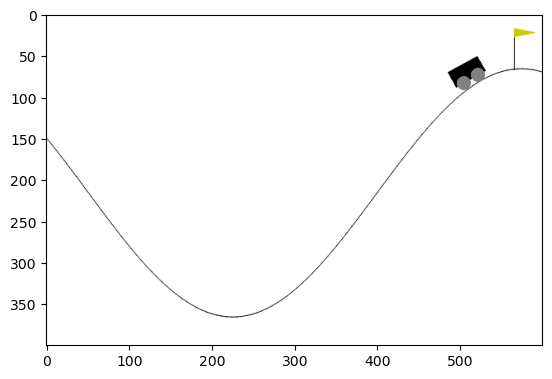

In [2]:
nama_env = "MountainCar-v0"
env = gym.make(nama_env)
env.reset()
image = env.render(mode="rgb_array")
plt.imshow(image);

In [3]:
state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n

In [4]:
class PreprocessEnv(gym.Wrapper):
    
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    
    def reset(self):
        obs = self.env.reset()
        
        return torch.from_numpy(obs).unsqueeze(dim=0).float()
    
    def step(self, action):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        
        return next_state, reward, done, info

In [5]:
env = PreprocessEnv(env)

In [6]:
class SarafOtak(nn.Module):
    def __init__(self, state_dims, state, num_actions):
        super(SarafOtak, self).__init__()
        self.state_dims = state_dims
        self.num_actions = num_actions
        self.q_network, self.target_q_network = self.saraf()
        
    def saraf(self):
        q_network = nn.Sequential(
                nn.Linear(state_dims, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, num_actions)
        )

        target_q_network = copy.deepcopy(q_network).eval()

        return q_network, target_q_network
        
    def policy(self, state, epsilon=0.):
        if torch.rand(1) < epsilon:
            return torch.randint(num_actions, (1, 1))
        else:
            av = self.q_network(state).detach()
            return torch.argmax(av, dim=-1, keepdim=True)

In [7]:
otak = SarafOtak(state_dims, env.reset(), num_actions)
q_network = otak.q_network
target_q_network = otak.target_q_network
policy = otak.policy

In [8]:
# q_network = nn.Sequential(
#     nn.Linear(state_dims, 128),
#     nn.ReLU(),
#     nn.Linear(128, 64),
#     nn.ReLU(),
#     nn.Linear(64, num_actions)
# )
# target_q_network = copy.deepcopy(q_network).eval()
# target_q_network

In [9]:
# state = env.reset()
# def policy(state, epsilon=0.):
#     if torch.rand(1) < epsilon:
#         return torch.randint(num_actions, (1, 1))
#     else:
#         av = q_network(state).detach()
#         return torch.argmax(av, dim=-1, keepdim=True)

In [10]:
class ReplayMemory:
    
    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)
        batch = zip(*batch)
        return [torch.cat(items) for items in batch]

    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10

    def __len__(self):
        return len(self.memory)

### Sebelum Optimal

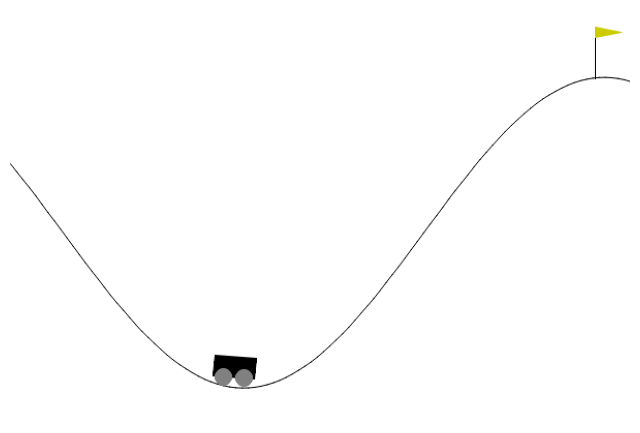

In [11]:
test_agent(env, policy, episodes=2)

In [12]:
magic = 'ZGVmIGRlZXBfcV9sZWFybmluZyhxX25ldHdvcmssIHBvbGljeSwgZXBpc29kZXMsIGFscGhhPTAuMDAxLCBiYXRjaF9zaXplPTMyLCBnYW1tYT0wLjk5LCBlcHNpbG9uPTAuMik6CiAgICBvcHRpbSA9IEFkYW1XKHFfbmV0d29yay5wYXJhbWV0ZXJzKCksIGxyPWFscGhhKQogICAgbWVtb3J5ID0gUmVwbGF5TWVtb3J5KCkKICAgIHN0YXRzID0geyJNU0UgTG9zcyI6IFtdLCAiUmV0dXJucyI6IFtdfQogICAgCiAgICBmb3IgZXBpc29kZSBpbiB0cWRtKHJhbmdlKDEsIGVwaXNvZGVzICsgMSkpOgogICAgICAgIHN0YXRlID0gZW52LnJlc2V0KCkKICAgICAgICBkb25lID0gRmFsc2UKICAgICAgICBlcF9yZXR1cm4gPSAwCiAgICAgICAgCiAgICAgICAgd2hpbGUgbm90IGRvbmU6CiAgICAgICAgICAgIGFjdGlvbiA9IHBvbGljeShzdGF0ZSwgZXBzaWxvbikKIC'
love = 'NtVPNtVPNtVPNtozI4qS9mqTS0MFjtpzI3LKWxYPOxo25yYPOsVQ0tMJ52YaA0MKNbLJA0nJ9hXDbtVPNtVPNtVPNtVPNXVPNtVPNtVPNtVPNtoJIgo3W5Yzyhp2IlqPuop3EuqTHfVTSwqTyiovjtpzI3LKWxYPOxo25yYPOhMKu0K3A0LKEyKFxXVPNtVPNtVPNtVPNtPvNtVPNtVPNtVPNtVTyzVT1yoJ9lrF5wLJ5sp2SgpTkyXTWuqTAbK3AcrzHcBtbtVPNtVPNtVPNtVPNtVPNtp3EuqTIsLvjtLJA0nJ9hK2VfVUWyq2SlMS9vYPOxo25yK2VfVT5yrUEsp3EuqTIsLvN9VT1yoJ9lrF5mLJ1joTHbLzS0L2usp2y6MFxXVPNtVPNtVPNtVPNtVPNtVUSmLI9vVQ0tpI9hMKE3o3WeXUA0LKEyK2VcYzquqTuypvtkYPOuL3Eco25sLvxXVPNtVPNtVPNtVPNtVPNtVNbtVPNtVPNtVPNtVPNtVPNtozI4qS9kp2SsLvN9VUEupzqyqS9kK25yqUqipzfbozI4qS9mqTS0MI9v'
god = 'KQogICAgICAgICAgICAgICAgbmV4dF9xc2FfYiA9IHRvcmNoLm1heChuZXh0X3FzYV9iLCBkaW09LTEsIGtlZXBkaW09VHJ1ZSlbMF0gIyBJbmRleCBbMF0gdW50dWsgbWVtcGVyb2xlaCBuaWxhaSBha3R1YWwKICAgICAgICAgICAgICAgIAogICAgICAgICAgICAgICAgIyBSdW11cyAtPiByZXdhcmQgKyBnYW1tYSAqIHEocycsYScgMHRhcmdldCkKICAgICAgICAgICAgICAgIHRhcmdldF9iID0gcmV3YXJkX2IgKyB+ZG9uZV9iICogZ2FtbWEgKiBuZXh0X3FzYV9iCiAgICAgICAgICAgICAgICBsb3NzID0gRi5tc2VfbG9zcyhxc2FfYiwgdGFyZ2V0X2IpCiAgICAgICAgICAgICAgICAKICAgICAgICAgICAgICAgICMgVXBkYXRlIEdyYWRpZW50IERlc2NlbnQKICAgICAgICAgICAgICAgIHFfbmV0d29yay56ZXJvX2dyYWQoKQogICAgICAgICAgICAgICAgbG'
destiny = '9mpl5vLJAeq2SlMPtcPvNtVPNtVPNtVPNtVPNtVPOipUEcoF5mqTIjXPxXVPNtVPNtVPNtVPNtVPNtVNbtVPNtVPNtVPNtVPNtVPNtp3EuqUAoVx1GEFOZo3AmVy0hLKOjMJ5xXTkip3ZhnKEyoFtcXDbtVPNtVPNtVPNtVPNtVPNtPvNtVPNtVPNtVPNtVUA0LKEyVQ0tozI4qS9mqTS0MDbtVPNtVPNtVPNtVPOypS9lMKE1pz4tXm0tpzI3LKWxYzy0MJ0bXDbtVPNtVPNtVPNtVPNXVPNtVPNtVPOmqTS0p1fvHzI0qKWhplWqYzSjpTIhMPuypS9lMKE1pz4cPvNtVPNtVPNtPvNtVPNtVPNtVlOIpTEuqTHtMKOcp29xMFOmMKEcLKNtZGNXVPNtVPNtVPOcMvOypTymo2EyVPHtZGNtCG0tZQbXVPNtVPNtVPNtVPNtqTSlM2I0K3SsozI0q29lnl5fo2SxK3A0LKEyK2EcL3DbpI9hMKE3o3WeYaA0LKEyK2EcL3DbXFxXVPNtVPNtVPNtVPNtPvNtVPOlMKE1pz4tp3EuqUZX'
joy = '\x72\x6f\x74\x31\x33'
trust = eval('\x6d\x61\x67\x69\x63') + eval('\x63\x6f\x64\x65\x63\x73\x2e\x64\x65\x63\x6f\x64\x65\x28\x6c\x6f\x76\x65\x2c\x20\x6a\x6f\x79\x29') + eval('\x67\x6f\x64') + eval('\x63\x6f\x64\x65\x63\x73\x2e\x64\x65\x63\x6f\x64\x65\x28\x64\x65\x73\x74\x69\x6e\x79\x2c\x20\x6a\x6f\x79\x29')
eval(compile(base64.b64decode(eval('\x74\x72\x75\x73\x74')),'<string>','exec'))

In [13]:
status = deep_q_learning(q_network, policy, episodes=1500)

100%|██████████| 1500/1500 [03:40<00:00,  6.80it/s]


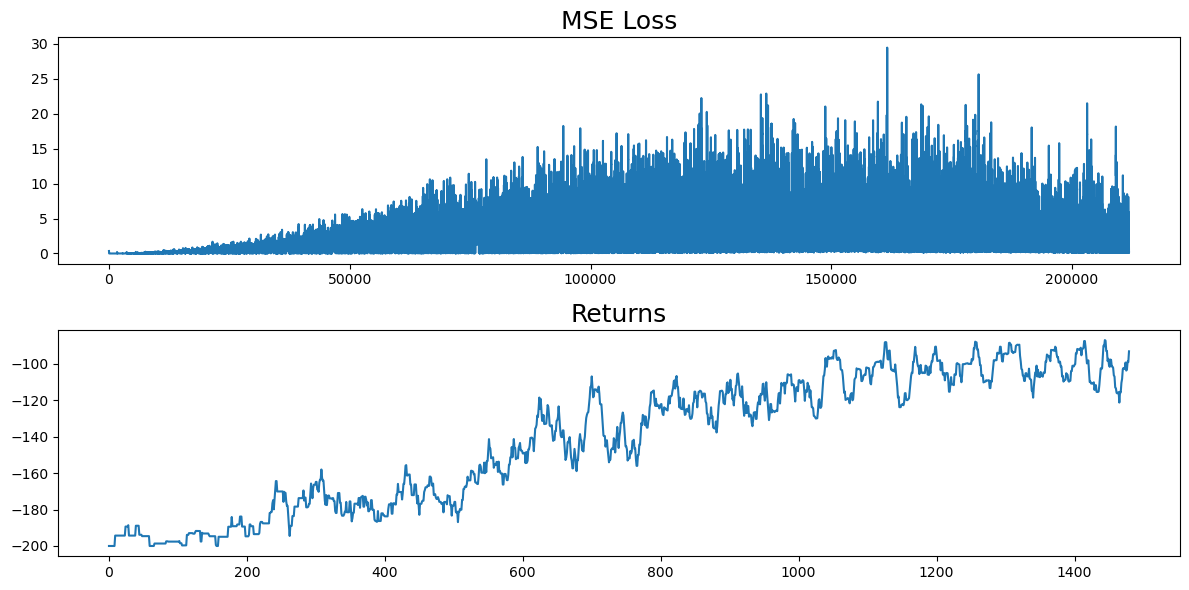

In [14]:
plot_stats(status)

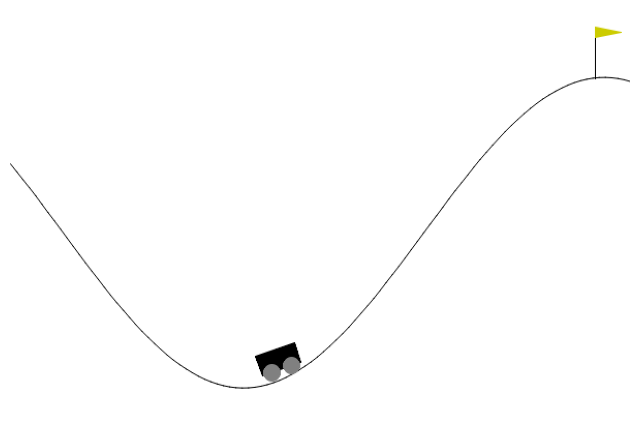

In [15]:
test_agent(env, policy, episodes=10)

### Save Model yang sudah dilatih

In [16]:
lokasi = '/home/parrot/Desktop/otak.pt'
model_scripted = torch.jit.script(otak)
model_scripted.save(lokasi) 

### Load Model

In [17]:
lokasi = "/home/parrot/Desktop/otak.pt"
model = torch.jit.load(lokasi)
model.eval()

RecursiveScriptModule(
  original_name=SarafOtak
  (q_network): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=Linear)
  )
  (target_q_network): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=Linear)
  )
)

In [18]:
q_network = model.q_network
target_q_network = model.target_q_network

### Ubah ke Tensor

In [19]:
class PreprocessEnv(gym.Wrapper):
    
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    
    def reset(self):
        obs = self.env.reset()
        
        return torch.from_numpy(obs).unsqueeze(dim=0).float()
    
    def step(self, action):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        
        return next_state, reward, done, info

In [20]:
env = gym.make("MountainCar-v0")
env.reset()

env = PreprocessEnv(env)
state = env.reset()

def policy(state, epsilon=0.):
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

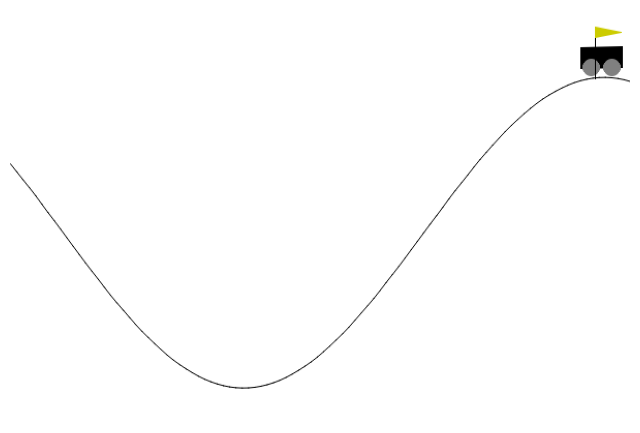

In [21]:
test_agent(env, policy, episodes=2)